In [1]:
import torch
import numpy as np
# from models import FlowNet2
from utils.frame_utils import read_gen
import argparse

In [2]:
class argparse():
    def __init__(self):
        super(argparse, self).__init__()
        self.rgb_max = 255.
        self.fp16 = False
        self.inference_size = [1080, 1920]
        self.crop_size = [384, 512]
        self.effective_batch_size = 1
        

In [3]:
args = argparse()

In [4]:
import torch.nn as nn
from torch.nn import init

import math
import numpy as np

try:
    from networks.resample2d_package.resample2d import Resample2d
    from networks.channelnorm_package.channelnorm import ChannelNorm

    from networks import FlowNetC
    from networks import FlowNetS
    from networks import FlowNetSD
    from networks import FlowNetFusion

    from networks.submodules import *
except:
    from .networks.resample2d_package.resample2d import Resample2d
    from .networks.channelnorm_package.channelnorm import ChannelNorm

    from .networks import FlowNetC
    from .networks import FlowNetS
    from .networks import FlowNetSD
    from .networks import FlowNetFusion

    from .networks.submodules import *
'Parameter count = 162,518,834'

'Parameter count = 162,518,834'

In [14]:
from models import *
import matplotlib.pyplot as plt

# Create Model

In [8]:
print('creating model.................')
net = FlowNet2(args).cuda()
print('loading weight.................')
state_dict = torch.load("FlowNet2_checkpoint.pth.tar")
net.load_state_dict(state_dict["state_dict"])

creating model.................
loading weight.................


<All keys matched successfully>

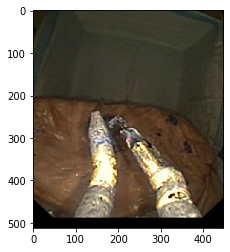

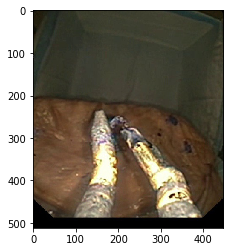

torch.Size([2, 384, 448])

In [129]:
# pim1 = read_gen("/home/projectx/Downloads/training/clean/ambush_5/frame_0037.png")
# pim2 = read_gen("/home/projectx/Downloads/training/clean/ambush_5/frame_0038.png")
pim1 = read_gen("/home/projectx/Documents/GitHub repos/VINET_modification/Train_1/caolin_frame0822.jpg")
pim2 = read_gen("/home/projectx/Documents/GitHub repos/VINET_modification/Train_1/caolin_frame0824.jpg")

images = [pim1[-384:,:], pim2[-384:,:]]
images = np.array(images).transpose(3, 0, 1, 2)
im = torch.from_numpy(images.astype(np.float32)).unsqueeze(0).cuda()
im.size()

plt.imshow(pim1)
plt.show()

plt.imshow(pim2)
plt.show()

result = net(im).squeeze()

result.size()

max flow: 8.7104
flow range:
u = -0.564 .. 8.535
v = -6.607 .. 0.399


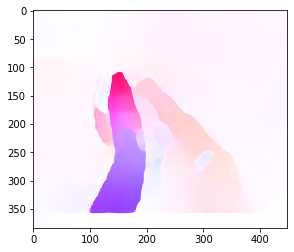

In [130]:
flow = result.data.cpu().numpy().transpose(1, 2, 0)
# flow.shape

image = flow_to_image(flow)

plt.imshow(image)
plt.show()

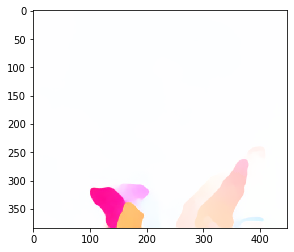

In [103]:
plt.imshow(image)
plt.show()

In [187]:
im = Image.fromarray(image,'RGB')
im.save('test_flow.png')
im.show()

In [160]:
def visualize_flow(flow, mode='Y'):
    """
    this function visualize the input flow
    :param flow: input flow in array
    :param mode: choose which color mode to visualize the flow (Y: Ccbcr, RGB: RGB color)
    :return: None
    """
    if mode == 'Y':
        # Ccbcr color wheel
        img = flow_to_image(flow)
        plt.imshow(img/255.)
        plt.show()
    
    return None

max flow: 47.0529
flow range:
u = -46.224 .. 2.482
v = -13.389 .. 10.017


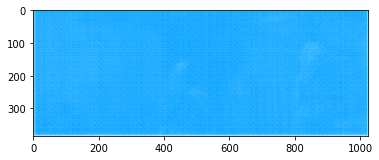

In [161]:
visualize_flow(flow)

In [91]:
import flowlib
from PIL import Image
def model_out_to_flow_png(output):
    out_np = output[0].data.cpu().numpy().transpose(1, 2, 0)

    #https://gitorchub.com/DediGadot/PatchBatch/blob/master/flowlib.py
    out_np = np.squeeze(out_np)
    out_np = np.moveaxis(out_np,0, -1)

    im_arr = flowlib.flow_to_image(out_np)
    im = Image.fromarray(im_arr)
    im.save('test.png')

In [92]:
img = np.array(result.data.cpu()).transpose(1, 2, 0)
im_arr = flowlib.flow_to_image(img)
im = Image.fromarray(im_arr)
im.save('test_flow.png')

max flow: 31.5244
flow range:
u = -5.077 .. 25.721
v = -19.467 .. 5.245


## Print method 2

In [75]:
flow_color = flow_vis.flow_to_color(img,convert_to_bgr=False)

In [86]:
im = Image.fromarray(flow_color,'RGB')
im.save('test_flow.png')
im.show()

In [21]:
# import png
import numpy as np
import matplotlib.colors as cl
import matplotlib.pyplot as plt
from PIL import Image


UNKNOWN_FLOW_THRESH = 1e7
SMALLFLOW = 0.0
LARGEFLOW = 1e8

"""
=============
Flow Section
=============
"""


def show_flow(filename):
    """
    visualize optical flow map using matplotlib
    :param filename: optical flow file
    :return: None
    """
    flow = read_flow(filename)
    img = flow_to_image(flow)
    plt.imshow(img)
    plt.show()


def visualize_flow(flow, mode='Y'):
    """
    this function visualize the input flow
    :param flow: input flow in array
    :param mode: choose which color mode to visualize the flow (Y: Ccbcr, RGB: RGB color)
    :return: None
    """
    if mode == 'Y':
        # Ccbcr color wheel
        img = flow_to_image(flow)
        plt.imshow(img)
        plt.show()
    elif mode == 'RGB':
        (h, w) = flow.shape[0:2]
        du = flow[:, :, 0]
        dv = flow[:, :, 1]
        valid = flow[:, :, 2]
        max_flow = max(np.max(du), np.max(dv))
        img = np.zeros((h, w, 3), dtype=np.float64)
        # angle layer
        img[:, :, 0] = np.arctan2(dv, du) / (2 * np.pi)
        # magnitude layer, normalized to 1
        img[:, :, 1] = np.sqrt(du * du + dv * dv) * 8 / max_flow
        # phase layer
        img[:, :, 2] = 8 - img[:, :, 1]
        # clip to [0,1]
        small_idx = img[:, :, 0:3] < 0
        large_idx = img[:, :, 0:3] > 1
        img[small_idx] = 0
        img[large_idx] = 1
        # convert to rgb
        img = cl.hsv_to_rgb(img)
        # remove invalid point
        img[:, :, 0] = img[:, :, 0] * valid
        img[:, :, 1] = img[:, :, 1] * valid
        img[:, :, 2] = img[:, :, 2] * valid
        # show
        plt.imshow(img)
        plt.show()

    return None


def read_flow(filename):
    """
    read optical flow from Middlebury .flo file
    :param filename: name of the flow file
    :return: optical flow data in matrix
    """
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)
    data2d = None

    if 202021.25 != magic:
        print('Magic number incorrect. Invalid .flo file')
    else:
        w = np.fromfile(f, np.int32, count=1)
        h = np.fromfile(f, np.int32, count=1)
        print("Reading %d x %d flo file" % (h, w))
        data2d = np.fromfile(f, np.float32, count=2 * w * h)
        # reshape data into 3D array (columns, rows, channels)
        data2d = np.resize(data2d, (h[0], w[0], 2))
    f.close()
    return data2d


# def read_flow_png(flow_file):
#     """
#     Read optical flow from KITTI .png file
#     :param flow_file: name of the flow file
#     :return: optical flow data in matrix
#     """
#     flow_object = png.Reader(filename=flow_file)
#     flow_direct = flow_object.asDirect()
#     flow_data = list(flow_direct[2])
#     (w, h) = flow_direct[3]['size']
#     flow = np.zeros((h, w, 3), dtype=np.float64)
#     for i in range(len(flow_data)):
#         flow[i, :, 0] = flow_data[i][0::3]
#         flow[i, :, 1] = flow_data[i][1::3]
#         flow[i, :, 2] = flow_data[i][2::3]

#     invalid_idx = (flow[:, :, 2] == 0)
#     flow[:, :, 0:2] = (flow[:, :, 0:2] - 2 ** 15) / 64.0
#     flow[invalid_idx, 0] = 0
#     flow[invalid_idx, 1] = 0
#     return flow


def write_flow(flow, filename):
    """
    write optical flow in Middlebury .flo format
    :param flow: optical flow map
    :param filename: optical flow file path to be saved
    :return: None
    """
    f = open(filename, 'wb')
    magic = np.array([202021.25], dtype=np.float32)
    (height, width) = flow.shape[0:2]
    w = np.array([width], dtype=np.int32)
    h = np.array([height], dtype=np.int32)
    magic.tofile(f)
    w.tofile(f)
    h.tofile(f)
    flow.tofile(f)
    f.close()


def segment_flow(flow):
    h = flow.shape[0]
    w = flow.shape[1]
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    idx = ((abs(u) > LARGEFLOW) | (abs(v) > LARGEFLOW))
    idx2 = (abs(u) == SMALLFLOW)
    class0 = (v == 0) & (u == 0)
    u[idx2] = 0.00001
    tan_value = v / u

    class1 = (tan_value < 1) & (tan_value >= 0) & (u > 0) & (v >= 0)
    class2 = (tan_value >= 1) & (u >= 0) & (v >= 0)
    class3 = (tan_value < -1) & (u <= 0) & (v >= 0)
    class4 = (tan_value < 0) & (tan_value >= -1) & (u < 0) & (v >= 0)
    class8 = (tan_value >= -1) & (tan_value < 0) & (u > 0) & (v <= 0)
    class7 = (tan_value < -1) & (u >= 0) & (v <= 0)
    class6 = (tan_value >= 1) & (u <= 0) & (v <= 0)
    class5 = (tan_value >= 0) & (tan_value < 1) & (u < 0) & (v <= 0)

    seg = np.zeros((h, w))

    seg[class1] = 1
    seg[class2] = 2
    seg[class3] = 3
    seg[class4] = 4
    seg[class5] = 5
    seg[class6] = 6
    seg[class7] = 7
    seg[class8] = 8
    seg[class0] = 0
    seg[idx] = 0

    return seg


def flow_error(tu, tv, u, v):
    """
    Calculate average end point error
    :param tu: ground-truth horizontal flow map
    :param tv: ground-truth vertical flow map
    :param u:  estimated horizontal flow map
    :param v:  estimated vertical flow map
    :return: End point error of the estimated flow
    """
    smallflow = 0.0
    '''
    stu = tu[bord+1:end-bord,bord+1:end-bord]
    stv = tv[bord+1:end-bord,bord+1:end-bord]
    su = u[bord+1:end-bord,bord+1:end-bord]
    sv = v[bord+1:end-bord,bord+1:end-bord]
    '''
    stu = tu[:]
    stv = tv[:]
    su = u[:]
    sv = v[:]

    idxUnknow = (abs(stu) > UNKNOWN_FLOW_THRESH) | (abs(stv) > UNKNOWN_FLOW_THRESH)
    stu[idxUnknow] = 0
    stv[idxUnknow] = 0
    su[idxUnknow] = 0
    sv[idxUnknow] = 0

    ind2 = [(np.absolute(stu) > smallflow) | (np.absolute(stv) > smallflow)]
    index_su = su[ind2]
    index_sv = sv[ind2]
    an = 1.0 / np.sqrt(index_su ** 2 + index_sv ** 2 + 1)
    un = index_su * an
    vn = index_sv * an

    index_stu = stu[ind2]
    index_stv = stv[ind2]
    tn = 1.0 / np.sqrt(index_stu ** 2 + index_stv ** 2 + 1)
    tun = index_stu * tn
    tvn = index_stv * tn

    '''
    angle = un * tun + vn * tvn + (an * tn)
    index = [angle == 1.0]
    angle[index] = 0.999
    ang = np.arccos(angle)
    mang = np.mean(ang)
    mang = mang * 180 / np.pi
    '''

    epe = np.sqrt((stu - su) ** 2 + (stv - sv) ** 2)
    epe = epe[ind2]
    mepe = np.mean(epe)
    return mepe


def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    print("max flow: %.4f\nflow range:\nu = %.3f .. %.3f\nv = %.3f .. %.3f" % (maxrad, minu,maxu, minv, maxv))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)


def evaluate_flow_file(gt, pred):
    """
    evaluate the estimated optical flow end point error according to ground truth provided
    :param gt: ground truth file path
    :param pred: estimated optical flow file path
    :return: end point error, float32
    """
    # Read flow files and calculate the errors
    gt_flow = read_flow(gt)        # ground truth flow
    eva_flow = read_flow(pred)     # predicted flow
    # Calculate errors
    average_pe = flow_error(gt_flow[:, :, 0], gt_flow[:, :, 1], eva_flow[:, :, 0], eva_flow[:, :, 1])
    return average_pe


def evaluate_flow(gt_flow, pred_flow):
    """
    gt: ground-truth flow
    pred: estimated flow
    """
    average_pe = flow_error(gt_flow[:, :, 0], gt_flow[:, :, 1], pred_flow[:, :, 0], pred_flow[:, :, 1])
    return average_pe


"""
==============
Disparity Section
==============
"""

# 
# def read_disp_png(file_name):
#     """
#     Read optical flow from KITTI .png file
#     :param file_name: name of the flow file
#     :return: optical flow data in matrix
#     """
#     image_object = png.Reader(filename=file_name)
#     image_direct = image_object.asDirect()
#     image_data = list(image_direct[2])
#     (w, h) = image_direct[3]['size']
#     channel = len(image_data[0]) / w
#     flow = np.zeros((h, w, channel), dtype=np.uint16)
#     for i in range(len(image_data)):
#         for j in range(channel):
#             flow[i, :, j] = image_data[i][j::channel]
#     return flow[:, :, 0] / 256


def disp_to_flowfile(disp, filename):
    """
    Read KITTI disparity file in png format
    :param disp: disparity matrix
    :param filename: the flow file name to save
    :return: None
    """
    f = open(filename, 'wb')
    magic = np.array([202021.25], dtype=np.float32)
    (height, width) = disp.shape[0:2]
    w = np.array([width], dtype=np.int32)
    h = np.array([height], dtype=np.int32)
    empty_map = np.zeros((height, width), dtype=np.float32)
    data = np.dstack((disp, empty_map))
    magic.tofile(f)
    w.tofile(f)
    h.tofile(f)
    data.tofile(f)
    f.close()


"""
==============
Image Section
==============
"""


def read_image(filename):
    """
    Read normal image of any format
    :param filename: name of the image file
    :return: image data in matrix uint8 type
    """
    img = Image.open(filename)
    im = np.array(img)
    return im


def warp_image(im, flow):
    """
    Use optical flow to warp image to the next
    :param im: image to warp
    :param flow: optical flow
    :return: warped image
    """
    from scipy import interpolate
    image_height = im.shape[0]
    image_width = im.shape[1]
    flow_height = flow.shape[0]
    flow_width = flow.shape[1]
    n = image_height * image_width
    (iy, ix) = np.mgrid[0:image_height, 0:image_width]
    (fy, fx) = np.mgrid[0:flow_height, 0:flow_width]
    fx += flow[:,:,0]
    fy += flow[:,:,1]
    mask = np.logical_or(fx <0 , fx > flow_width)
    mask = np.logical_or(mask, fy < 0)
    mask = np.logical_or(mask, fy > flow_height)
    fx = np.minimum(np.maximum(fx, 0), flow_width)
    fy = np.minimum(np.maximum(fy, 0), flow_height)
    points = np.concatenate((ix.reshape(n,1), iy.reshape(n,1)), axis=1)
    xi = np.concatenate((fx.reshape(n, 1), fy.reshape(n,1)), axis=1)
    warp = np.zeros((image_height, image_width, im.shape[2]))
    for i in range(im.shape[2]):
        channel = im[:, :, i]
        plt.imshow(channel, cmap='gray')
        values = channel.reshape(n, 1)
        new_channel = interpolate.griddata(points, values, xi, method='cubic')
        new_channel = np.reshape(new_channel, [flow_height, flow_width])
        new_channel[mask] = 1
        warp[:, :, i] = new_channel.astype(np.uint8)

    return warp.astype(np.uint8)


"""
==============
Others
==============
"""

def scale_image(image, new_range):
    """
    Linearly scale the image into desired range
    :param image: input image
    :param new_range: the new range to be aligned
    :return: image normalized in new range
    """
    min_val = np.min(image).astype(np.float32)
    max_val = np.max(image).astype(np.float32)
    min_val_new = np.array(min(new_range), dtype=np.float32)
    max_val_new = np.array(max(new_range), dtype=np.float32)
    scaled_image = (image - min_val) / (max_val - min_val) * (max_val_new - min_val_new) + min_val_new
    return scaled_image.astype(np.uint8)


def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img


def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel
